In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib
import os
import random
import pandas as pd
import readFiles

plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 8,
  "ytick.labelsize"         : 8,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5,
})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/figures/'
#fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/figures/'

<IPython.core.display.Math object>

delta,,,phi_m,C,R2,,
1.0,,,0.789,2.296,0.999,,
1.4,,,0.788,2.284,0.999,,
2.0,,,0.794,2.270,1.000,,
4.0,,,0.824,2.355,0.999,,


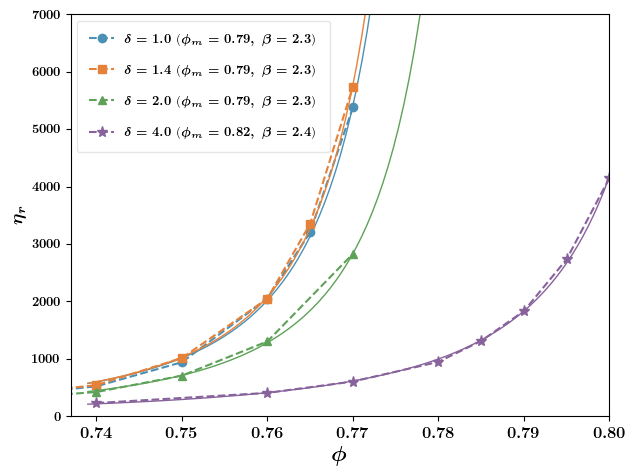

In [5]:
# maron pierce all plots
from IPython.display import HTML
from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings
from IPython.display import display, Math
warnings.filterwarnings("ignore", message="Mean of empty slice.", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

def maronpierce(x,c,k):
    base = 1 - (x / k)
    base = np.maximum(base, 1e-10)  # Prevent negative or zero base
    return 1 * (base ** -(c))

display(Math(r"\eta_r = 1 * \left( 1 - \frac{\phi}{\phi_m} \right)^{-c}"))

line_markers = ['o', 's', '^', '*', 'p']
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

#topDir = '/Volumes/rahul_2TB/high_bidispersity/new_data/'   #mac
topDir  = '/home/rahul/mnt/sshfs_darwin/simulations/'        #linux

# Parameters
npp     = 1000
phiv    = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
arr     = [1.0, 1.4, 2.0, 4.0]
vrr     = '0.5'
numRuns = 2
off     = 100
#phim    = []
#cvals   = []
c_guess = 3
k_guess = [.785,.785,.792,0.815]
           
# initial guess for max phi (phim)
# init table
table = PrettyTable()
column_names = ['delta', 'phi_m', "C", "R2"]
table.add_column(column_names[0], arr)
table.add_column(' ', [''] * len(arr))
table.add_column(' ', [''] * len(arr))

#fig, ax = plt.subplots(1, 3, figsize=(15, 4))
rerr    = [] # r2 error
phims   = [] # max phi calculated from fitting
c_list  = []

for j, arj in enumerate(arr):
    visc = []
    for k, phi in enumerate(phiv):
        phir      = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        visc_list = []
        for run in range(numRuns):
            vrj = '0.25' if arj == 1 else vrr
            workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrj}/run_{run+1}/"
            if os.path.exists(workDir):
                #print(workDir)
                dataFile = glob.glob(workDir+"data_*.dat")[0]
                data     = np.loadtxt(dataFile)
                visc_list.append(np.mean(data[off:, 3])) if len(data[off:, 3]) > off else None
        visc.append(np.mean(visc_list) if visc_list else np.nan) 

    visc_filtered     = [x for x in visc if not np.isnan(x)]
    phi_vals_filtered = [y for x, y in zip(visc, phiv) if not np.isnan(x)]

    # curve fit
    popt, _   = curve_fit(maronpierce, phi_vals_filtered,visc_filtered,p0=[c_guess, k_guess[j]])
    c_opt, k_opt = popt
    phims.append(k_opt)
    msize = 8 if line_markers[j] == '*' else 6
    plt.plot(phi_vals_filtered, visc_filtered,linestyle='--',marker=line_markers[j], 
             label=r'$\delta = {:.1f}$ ($\phi_m = {:.2f}, \; \beta = {:.1f}$)'.format(arj,k_opt,c_opt), 
             color=colors[j],linewidth=1.5,markersize=msize)
    #print(f"Optimal value for c (del = {arj:.1f}): {c_opt:.4f}")
    c_list.append(c_opt)

    # plotting for model
    xx = np.linspace(0.739, .80, 100)
    yy = maronpierce(xx,c_opt,k_opt)
    plt.plot(xx, yy,color=colors[j])

    #coefficient of determinantion (r^2)
    r2 = True
    if r2:
        # calculating the r2 for each curve
        y_predicted = [maronpierce(i, *popt) for i in phi_vals_filtered]
        residuals = [a - b for a, b in zip(visc_filtered, y_predicted)]
        TSS = np.sum((visc_filtered - np.mean(visc_filtered))**2)
        RSS = np.sum([i**2 for i in residuals])
        R_squared = 1 - (RSS / TSS)
        rerr.append(R_squared)
        #print("R-squared value:", R_squared)


#ax[i].grid(which='Both', alpha=0.2)
plt.xlim(.737, .80)
plt.ylim(0, 7000)
plt.xlabel(r'$\mathbf{\phi}$', fontsize=16,fontstyle='italic')
plt.tick_params(axis='x', labelsize=12)
plt.legend(loc='upper left', fontsize=9,labelspacing=1.5,borderpad=1,framealpha=0.5)
#plt.title(fr'$\zeta = {vrr}0$', fontsize=13, pad=10)

# table
table.add_column(column_names[1], ["{:.3f}".format(x) for x in phims])
table.add_column(column_names[2], ["{:.3f}".format(x) for x in c_list])
table.add_column(column_names[3], ["{:.3f}".format(x) for x in rerr])
table.add_column(' ', [''] * len(arr))
table.add_column(' ', [''] * len(arr))

# plot parameters
plt.ylabel(r'$\mathbf{\eta}_{r}$', fontsize=13, fontstyle='italic')
plt.tick_params(axis='y', labelsize=9)

# table disp
html_table = f"""
<div style='display: flex; justify-content: center;'>
    {table.get_html_string()}
</div>
"""
display(HTML(html_table))
plt.tight_layout()

figsave=True
if figsave:
    figFormat=".svg"
    plt.savefig(f"{fig_save_path}Maron-Pierce_vr_{vrr}{figFormat}", bbox_inches="tight", dpi=600, transparent=True)

plt.show()

In [10]:
kk = np.loadtxt('/home/rahul/Downloads/NP 1000 (2r)viscosity_by_phi_tables.txt')

In [11]:
kk.shape

(4004, 4)

[62.12718636363636, 115.80095731707317, 163.36811474501107, 234.56015538290788]
[48.01983447893569, 71.17411951219512, 92.77412294900222, 120.72492253052165]
[27.113079933481153, 34.00814689578714, 38.72647028824834, 50.84388390677026]


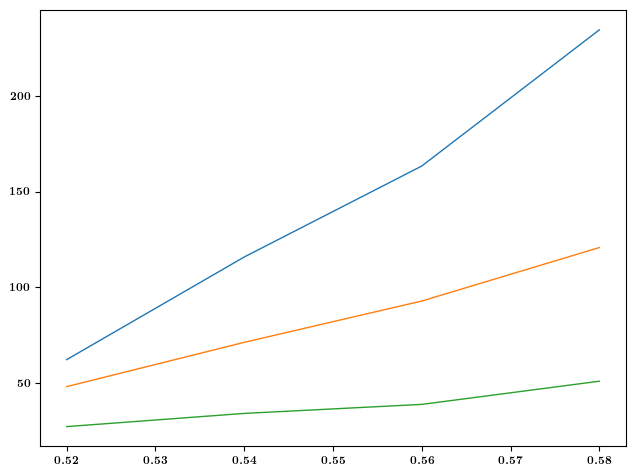

In [12]:
phi = [0.52, 0.54, 0.56, 0.58]
ar  = [1.4, 2.0, 4.0]
tn  = 1001
off = 100

data3d = np.loadtxt('/home/rahul/Downloads/NP 1000 (2r)viscosity_by_phi_tables.txt')
line_markers = ['o', 's', '^', '*', 'p']
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

for i, arr in enumerate(ar):
    ar_visc = []
    for j, phii in enumerate(phi):
        data = data3d[tn*j:tn*(j+1)+1, i+1]
        visc = np.mean(data[off:])
        ar_visc.append(visc)
    print(ar_visc)
    plt.plot(phi, ar_visc)

<IPython.core.display.Math object>

delta,phi_m,C,R2
1.0,0.789,2.296,0.999
1.4,0.788,2.284,0.999
2.0,0.794,2.270,1.000
4.0,0.824,2.355,0.999
delta,phi_m,C,R2
1.4,0.612,2.218,0.998
2.0,0.640,2.306,0.999
4.0,0.671,2.170,0.965


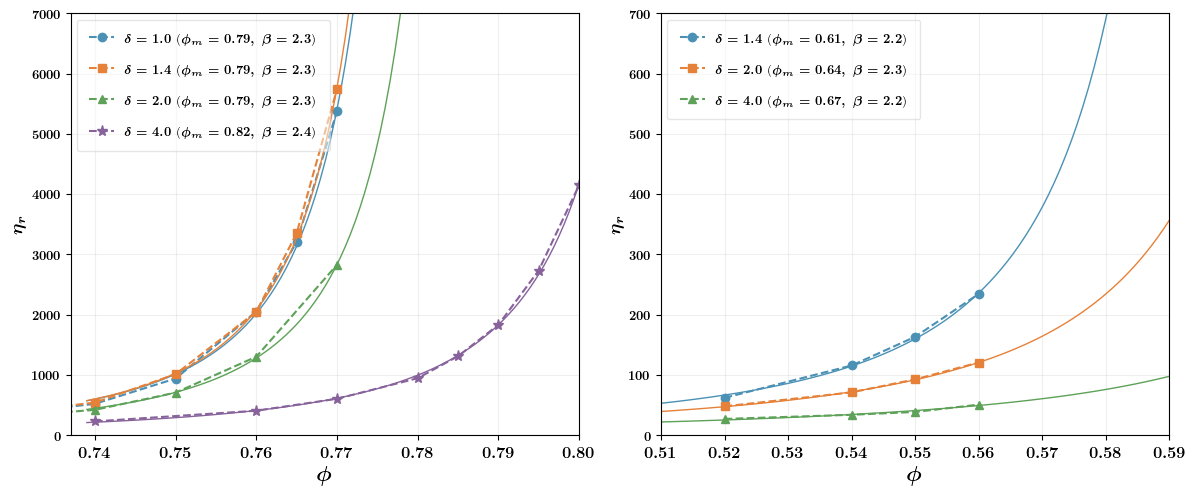

In [75]:
# Maron-Pierce all plots
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Mean of empty slice.", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

# Maron-Pierce model function
def maronpierce(x, c, k):
    base = 1 - (x / k)
    base = np.maximum(base, 1e-10)  # Prevent zero or negative base
    return base ** (-c)

# Show the Maron-Pierce equation
display(Math(r"\eta_r = \left( 1 - \frac{\phi}{\phi_m} \right)^{-c}"))

# Plot style settings
line_markers = ['o', 's', '^', '*', 'p']
colors       = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

# File directories
# topDir = '/Volumes/rahul_2TB/high_bidispersity/new_data/'    # Mac
topDir = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'  # Linux

# Parameters
npp = 1000
phiv = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar2d = [1.0, 1.4, 2.0, 4.0]
vrr = '0.5'
numRuns = 2
offset = 100
c_guess = 3
k_guess_2d = [0.785, 0.785, 0.792, 0.815]

# # Prepare results table
# table = PrettyTable()
# table.field_names = ['delta', 'phi_m', 'C', 'R2']
# table.add_column('delta', ar2d)
# table.add_column('phi_m', [''] * len(ar2d))
# table.add_column('C',     [''] * len(ar2d))
# table.add_column('R2',    [''] * len(ar2d))

# Initialize plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
rerr    = []
phims   = []
c_list  = []

# --- 2D Data ---
for j, arj in enumerate(ar2d):
    visc = []
    for phi in phiv:
        phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        visc_list = []
        for run in range(numRuns):
            vrj = '0.25' if arj == 1 else vrr
            workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrj}/run_{run+1}/"
            if os.path.exists(workDir):
                dataFile = glob.glob(workDir + "data_*.dat")[0]
                data = np.loadtxt(dataFile)
                if len(data[offset:, 3]) > 0:
                    visc_list.append(np.mean(data[offset:, 3]))
        visc.append(np.mean(visc_list) if visc_list else np.nan)

    # Filter NaNs
    visc_filtered = [x for x in visc if not np.isnan(x)]
    phi_vals_filtered = [y for x, y in zip(visc, phiv) if not np.isnan(x)]

    # Fit model
    popt, _      = curve_fit(maronpierce, phi_vals_filtered, visc_filtered, p0=[c_guess, k_guess_2d[j]])
    c_opt, k_opt = popt
    phims.append(k_opt)
    c_list.append(c_opt)

    # Plot data
    msize = 8 if line_markers[j] == '*' else 6
    ax[0].plot(phi_vals_filtered, visc_filtered, linestyle='--', marker=line_markers[j],
               label=fr'$\delta = {arj:.1f}$ ($\phi_m = {k_opt:.2f}, \; \beta = {c_opt:.1f}$)',
               color=colors[j], linewidth=1.5, markersize=msize)
    xx = np.linspace(0.739, 0.80, 100)
    yy = maronpierce(xx, c_opt, k_opt)
    ax[0].plot(xx, yy, color=colors[j])

    # Compute R²
    y_predicted = maronpierce(np.array(phi_vals_filtered), *popt)
    residuals = np.array(visc_filtered) - y_predicted
    TSS = np.sum((visc_filtered - np.mean(visc_filtered)) ** 2)
    RSS = np.sum(residuals ** 2)
    R_squared = 1 - (RSS / TSS)
    rerr.append(R_squared)

# Update table
table_2d = PrettyTable()
table_2d.field_names = ['delta', 'phi_m', 'C', 'R2']
for i in range(len(ar2d)):
    table_2d.add_row([f"{ar2d[i]:.1f}", f"{phims[i]:.3f}", f"{c_list[i]:.3f}", f"{rerr[i]:.3f}"])

html_table_2d = f"""
<div style='text-align: center;'>
    <h4>2D Fit Results</h4>
    {table_2d.get_html_string()}
</div>
"""
#display(HTML(html_table))

# --- 3D Data ---
phi_3d  = [0.52, 0.54, 0.55, 0.56]
ar3d    = [1.4, 2.0, 4.0]
tn      = 1001
c_guess = 2.5
k_guess_3d = [0.63, 0.66, 0.71]

data3d = np.loadtxt('/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/NP 1000 (2r)viscosity_by_phi_tables.txt')

rerr    = []
phims   = []
c_list  = []

for i, arj in enumerate(ar3d):
    ar_visc = []
    for j, phii in enumerate(phi_3d):
        data = data3d[tn * j:tn * (j + 1) + 1, i + 1]
        visc = np.mean(data[offset:])
        ar_visc.append(visc)

    popt, _ = curve_fit(maronpierce, phi_3d, ar_visc, p0=[c_guess, k_guess_3d[i]])
    c_opt, k_opt = popt
    phims.append(k_opt)
    c_list.append(c_opt)

    msize = 8 if line_markers[i] == '*' else 6
    ax[1].plot(phi_3d, ar_visc, linestyle='--', marker=line_markers[i],
               label=fr'$\delta = {arj:.1f}$ ($\phi_m = {k_opt:.2f}, \; \beta = {c_opt:.1f}$)',
               color=colors[i], linewidth=1.5, markersize=msize)
    xx = np.linspace(0.51, 0.60, 100)
    yy = maronpierce(xx, c_opt, k_opt)
    ax[1].plot(xx, yy, color=colors[i])

    # Compute R²
    y_predicted = maronpierce(np.array(phi_3d), *popt)
    residuals = np.array(ar_visc) - y_predicted
    TSS = np.sum((ar_visc - np.mean(ar_visc)) ** 2)
    RSS = np.sum(residuals ** 2)
    R_squared = 1 - (RSS / TSS)
    rerr.append(R_squared)
    
# Update table
table_3d = PrettyTable()
table_3d.field_names = ['delta', 'phi_m', 'C', 'R2']
for i in range(len(ar3d)):
    idx = i #+ len(ar2d)
    table_3d.add_row([f"{ar3d[i]:.1f}", f"{phims[idx]:.3f}", f"{c_list[idx]:.3f}", f"{rerr[idx]:.3f}"])
    
html_table_3d = f"""
<div style='text-align: center;'>
    <h4>3D Fit Results</h4>
    {table_3d.get_html_string()}
</div>
"""
combined_html = f"""
<div style='display: flex; justify-content: center; gap: 40px;'>
    {html_table_2d}
    {html_table_3d}
</div>
"""
display(HTML(combined_html))

# --- Final plot formatting ---
ax[0].set_xlim(0.737, 0.80)
ax[0].set_ylim(0, 7000)
ax[0].set_xlabel(r'$\mathbf{\phi}$', fontsize=16, fontstyle='italic')
ax[0].set_ylabel(r'$\mathbf{\eta}_{r}$', fontsize=13, fontstyle='italic')
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=9)
ax[0].legend(loc='upper left', fontsize=9, labelspacing=1.5, borderpad=1, framealpha=0.5)
ax[0].grid(which='both', alpha=0.2)

ax[1].set_xlim(0.51, 0.59)
ax[1].set_ylim(0, 700)
ax[1].set_xlabel(r'$\mathbf{\phi}$', fontsize=16, fontstyle='italic')
ax[1].set_ylabel(r'$\mathbf{\eta}_{r}$', fontsize=13, fontstyle='italic')
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=9)
ax[1].legend(loc='upper left', fontsize=9, labelspacing=1.5, borderpad=1, framealpha=0.5)
ax[1].grid(which='both', alpha=0.2)

plt.tight_layout()
plt.savefig(f"{fig_save_path}powerlaw_vr_{vrr}.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

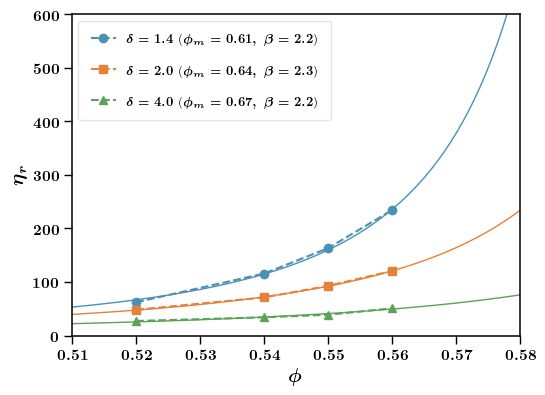

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def maronpierce(x, c, k):
    base = 1 - (x / k)
    base = np.maximum(base, 1e-10)  # Prevent zero or negative base
    return base ** (-c)
    
line_markers = ['o', 's', '^', '*', 'p']
colors       = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']
# Assuming maronpierce, line_markers, colors, offset, and fig_save_path are defined earlier in your script.

phi_3d  = [0.52, 0.54, 0.55, 0.56]
ar3d    = [1.4, 2.0, 4.0]
tn      = 1001
kn      = 500
off     = 100
c_guess = 2.5
k_guess_3d = [0.63, 0.66, 0.71]

data3d1 = np.loadtxt('/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/NP 1000 (2r)viscosity_by_phi_tables.txt')
#data3d2 = np.loadtxt('/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/viscosity_by_phi_tables_EAB2.txt')

rerr    = []
phims   = []
c_list  = []
#kk   = 0
# Create a single figure and axes
fig, ax = plt.subplots(figsize=(5.5,4))

for i, arj in enumerate(ar3d):
    ar_visc = []
    kk   = 0
    for j, phii in enumerate(phi_3d):
        data = data3d1[tn * j : tn * (j + 1) + 1, i + 1]
        visc = np.mean(data[off:])  # make sure 'offset' is defined somewhere in your code.
        ar_visc.append(visc)

    popt, _      = curve_fit(maronpierce, phi_3d, ar_visc, p0=[c_guess, k_guess_3d[i]])
    c_opt, k_opt = popt
    phims.append(k_opt)
    c_list.append(c_opt)

    msize = 8 if line_markers[i] == '*' else 6
    ax.plot(phi_3d, ar_visc, linestyle='--', marker=line_markers[i],
            label=fr'$\delta = {arj:.1f}$ ($\phi_m = {k_opt:.2f}, \; \beta = {c_opt:.1f}$)',
            color=colors[i], linewidth=1.5, markersize=msize)

    # Generate smooth curve for the fit
    xx = np.linspace(0.51, 0.60, 100)
    yy = maronpierce(xx, c_opt, k_opt)
    ax.plot(xx, yy, color=colors[i])

    # Compute R² for the current fit
    y_predicted = maronpierce(np.array(phi_3d), *popt)
    residuals   = np.array(ar_visc) - y_predicted
    TSS = np.sum((ar_visc - np.mean(ar_visc)) ** 2)
    RSS = np.sum(residuals ** 2)
    R_squared = 1 - (RSS / TSS)
    rerr.append(R_squared)

# Set axis limits, labels, and legend
# Set axis limits, labels, ticks, and legend
ax.set_xlim(0.51, 0.58)
ax.set_ylim(0, 600)
ax.set_xlabel(r'$\mathbf{\phi}$', fontsize=14, fontstyle='italic')
ax.set_ylabel(r'$\mathbf{\eta}_{r}$', fontsize=14, fontstyle='italic')
ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
ax.tick_params(axis='both', which='minor', labelsize=11, length=4, width=1)

# Set spine width
for spine in ax.spines.values():
    spine.set_linewidth(1.1)

ax.legend(loc='upper left', fontsize=9, labelspacing=1.5, borderpad=1, framealpha=0.5)
#ax.grid(which='both', alpha=0.2)

plt.tight_layout()
plt.savefig(f"{fig_save_path}powerlaw_3d2.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

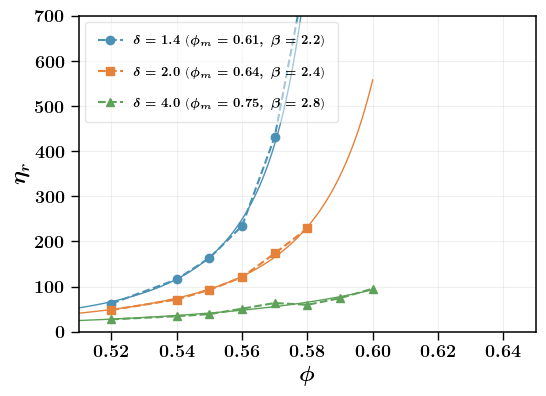

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def maronpierce(x, c, k):
    base = 1 - (x / k)
    base = np.maximum(base, 1e-10)  # Prevent zero or negative base
    return base ** (-c)
line_markers = ['o', 's', '^', '*', 'p']
colors       = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']
# Assuming maronpierce, line_markers, colors, offset, and fig_save_path are defined earlier in your script.

phi_3d  = [0.52, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60]
ar3d    = [1.4, 2.0, 4.0]
tn      = 1001
kn      = 500
off     = 100
c_guess = 2.2
k_guess_3d = [0.61, 0.63, 0.70]

data3d1 = np.loadtxt('/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/NP 1000 (2r)viscosity_by_phi_tables.txt')
data3d2 = np.loadtxt('/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/viscosity_by_phi_tables_EAB2.txt')

rerr    = []
phims   = []
c_list  = []
#kk   = 0
# Create a single figure and axes
fig, ax = plt.subplots(figsize=(5.5,4))

for i, arj in enumerate(ar3d):
    ar_visc = []
    kk   = 0
    for j, phii in enumerate(phi_3d):
        if phii < 0.57:
            data = data3d1[tn * j : tn * (j + 1) + 1, i + 1]
        else:
            #print(kk)
            data = data3d2[kn * kk : kn * (kk + 1) + 1, i + 1]
            kk += 1
            
        visc = np.mean(data[off:])  # make sure 'offset' is defined somewhere in your code.
        if ~np.isnan(visc).any():
            ar_visc.append(visc)
        else:
            ar_visc.append(np.nan)
            
    filtered_phi  = [phi_3d[i] for i,j in enumerate(ar_visc) if ~np.isnan(j)]
    filtered_visc = [j         for i,j in enumerate(ar_visc) if ~np.isnan(j)]
    
    popt, _      = curve_fit(maronpierce, filtered_phi, filtered_visc, p0=[c_guess, k_guess_3d[i]])
    c_opt, k_opt = popt
    phims.append(k_opt)
    c_list.append(c_opt)

    msize = 8 if line_markers[i] == '*' else 6
    ax.plot(phi_3d, ar_visc, linestyle='--', marker=line_markers[i],
            label=fr'$\delta = {arj:.1f}$ ($\phi_m = {k_opt:.2f}, \; \beta = {c_opt:.1f}$)',
            color=colors[i], linewidth=1.5, markersize=msize)

    # Generate smooth curve for the fit
    xx = np.linspace(0.51, 0.60, 100)
    yy = maronpierce(xx, c_opt, k_opt)
    ax.plot(xx, yy, color=colors[i])

    # Compute R² for the current fit
    y_predicted = maronpierce(np.array(phi_3d), *popt)
    residuals = np.array(ar_visc) - y_predicted
    TSS = np.sum((ar_visc - np.mean(ar_visc)) ** 2)
    RSS = np.sum(residuals ** 2)
    R_squared = 1 - (RSS / TSS)
    rerr.append(R_squared)

# Set axis limits, labels, and legend
# Set axis limits, labels, ticks, and legend
ax.set_xlim(0.51, 0.65)
ax.set_ylim(0, 700)
ax.set_xlabel(r'$\mathbf{\phi}$', fontsize=16, fontstyle='italic')
ax.set_ylabel(r'$\mathbf{\eta}_{r}$', fontsize=16, fontstyle='italic')
ax.tick_params(axis='both', which='major', labelsize=13, length=6, width=1)
ax.tick_params(axis='both', which='minor', labelsize=13, length=4, width=1)

# Set spine width
for spine in ax.spines.values():
    spine.set_linewidth(1.1)

ax.legend(loc='upper left', fontsize=9, labelspacing=1.5, borderpad=1, framealpha=0.5)
ax.grid(which='both', alpha=0.2)

plt.tight_layout()
#plt.savefig(f"{fig_save_path}powerlaw_3d.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

In [40]:
ar_visc

[27.093374894957982,
 33.97673634453782,
 38.913677731092434,
 50.84352723449001,
 63.70628802660754,
 60.44454301552106,
 75.11677095343681,
 95.54627303102626]

In [41]:
np.nanmean(data3d2[1000:1500, 3])

76.06877300000001

In [42]:
np.nanmean(data3d2[1500:2000, 3])

96.13763347547975

In [30]:
np.isnan(data3d2[0:500, 2]).any()

False

In [17]:
data

array([     nan,      nan,      nan,  17.3149,  17.5636,  18.0881,
        19.1958,  22.6087,  28.7756,  38.3657,  52.1588,  66.6967,
        86.8699, 112.683 , 152.816 , 216.933 , 247.106 , 319.427 ,
       404.686 , 482.007 , 451.306 , 474.987 , 478.564 , 496.265 ,
       551.21  , 636.939 , 550.205 , 521.614 , 513.112 , 596.342 ,
       547.508 , 460.056 , 496.696 , 551.74  , 516.637 , 472.428 ,
       553.895 , 633.377 , 626.826 , 666.342 , 749.426 , 744.965 ,
       660.371 , 680.231 , 858.82  , 866.859 , 984.786 , 554.956 ,
       539.443 , 525.422 , 635.42  , 448.152 , 498.444 , 512.491 ,
       479.591 , 459.186 , 494.848 , 615.49  , 501.503 , 552.269 ,
       600.072 , 650.481 , 850.502 , 769.094 , 773.124 , 882.488 ,
       873.469 , 598.643 , 767.884 , 615.549 , 582.679 , 612.676 ,
       706.18  , 767.663 , 807.22  , 670.886 , 485.183 , 527.299 ,
       620.427 , 470.991 , 510.582 , 415.218 , 475.256 , 424.966 ,
       506.617 , 573.28  , 568.572 , 649.128 , 635.191 , 677.0

In [14]:
data

array([], dtype=float64)

In [5]:
kk = np.loadtxt('/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/viscosity_by_phi_tables_EAB2.txt')

In [7]:
kk.shape

(1969, 4)

In [9]:
kk[500, 0]

500.0

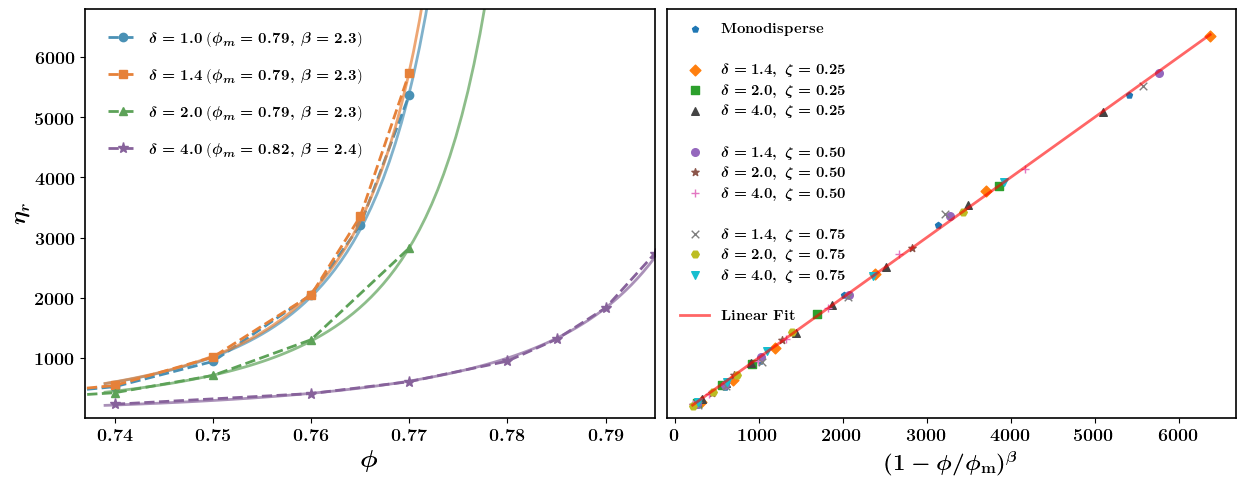

In [124]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings
import matplotlib.patches as patches

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Mean of empty slice.", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

# Define Maron-Pierce model
def maronpierce(x, c, k):
    base = 1 - (x / k)
    base = np.maximum(base, 1e-10)  # Avoid negative/zero base
    return (base ** -(c))

# Power law fitting
def power_law(x, a, b):
    return a * x**b

# Linear fit: y = m * x
def linear_fit(x, m):
    return m * x

# Plot styling
line_markers = ['o', 's', '^', '*', 'p']
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

# topDir = '/Volumes/rahul_2TB/high_bidispersity/new_data/'    # Mac
topDir = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'  # Linux

phim = [
    [0.7886717028827888, 0.7894387136954615, 0.793926329607985, 0.8324103075865033],
    [0.7886717028827888, 0.7877885526918533, 0.7939236898756902, 0.8239196866554372],
    [0.7886717028827888, 0.7885308930400247, 0.7900830006913417, 0.8044291017153138]
]
cvals = [
    [2.2961534930915994, 2.3650311285005365, 2.3581023842731605, 2.630286432009137],
    [2.2961534930915994, 2.2844228427617583, 2.2697625367992815, 2.355255703134564],
    [2.2961534930915994, 2.3000699722687648, 2.217088555299523, 2.2226341715514715]
]

# Parameters
npp  = 1000
phiv = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
arr  = [1.0, 1.4, 2.0, 4.0]
vrr  = '0.5'
numRuns = 2
off     = 100
c_guess = 3
k_guess = [0.785, 0.785, 0.792, 0.815]
fig, ax = plt.subplots(1, 2, figsize=(12.5, 4.9))
rerr, phims, c_list = [], [], []

for j, arj in enumerate(arr):
    visc = []
    
    for phi in phiv:
        phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        visc_list = []
        
        for run in range(numRuns):
            vrj = '0.25' if arj == 1 else vrr
            workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrj}/run_{run+1}/"
            
            if os.path.exists(workDir):
                dataFile = glob.glob(workDir + "data_*.dat")[0]
                data = np.loadtxt(dataFile)
                if len(data[off:, 3]) > off:
                    visc_list.append(np.mean(data[off:, 3]))
        
        visc.append(np.mean(visc_list) if visc_list else np.nan)

    # Remove NaN values for fitting
    visc_filtered = [x for x in visc if not np.isnan(x)]
    phi_vals_filtered = [y for x, y in zip(visc, phiv) if not np.isnan(x)]

    # Curve fitting
    popt, _ = curve_fit(maronpierce, phi_vals_filtered, visc_filtered, p0=[c_guess, k_guess[j]])
    c_opt, k_opt = popt
    phims.append(k_opt)
    c_list.append(c_opt)

    # Plot raw data
    msize = 8 if line_markers[j] == '*' else 6
    ax[0].plot(phi_vals_filtered, visc_filtered, linestyle='--', marker=line_markers[j], 
               label=rf'$\delta = {arj:.1f}$ ($\phi_m = {k_opt:.2f}, \; \beta = {c_opt:.1f}$)', 
               color=colors[j], linewidth=2, markersize=msize)

    # Plot Maron-Pierce model fit
    xx = np.linspace(0.739, 0.80, 100)
    yy = maronpierce(xx, c_opt, k_opt)
    ax[0].plot(xx, yy, color=colors[j], linewidth=2, alpha = 0.7)

#########################################################################################################

arr = [1.4, 2.0, 4.0]
vrr = ['0.25', '0.5', '0.75']
viscall = []
phimall = []
pcount  = 0

colors  = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#444444',
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#f6a821', '#f6d020',
    '#003366', '#cc6699'
]
marker_shape = ['p', 'D', 's', '^', 'o', '*', '+', 'x', 'H', 'v', '<', '>', '|']

## plotting ar = 1 and vr = 0.25 case first
visc1, viscerr1     = [], []
for k, phi in enumerate(phiv):
    phir      = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
    visc_list, viscerr_list = [], []
    for run in range(numRuns):
        phim_vals = [(1 - (i / phim[0][0])) ** -(cvals[0][0]) if phim[0][0] != 0 and (1 - (i / phim[0][0])) > 0 else float('nan') for i in phiv]
        workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_1.0/Vr_0.25/run_{run+1}/"
        if os.path.exists(workDir):
            #print(workDir)
            dataFile = glob.glob(workDir+"data_*.dat")[0]
            data     = np.loadtxt(dataFile)
            visc_list.append(np.mean(data[off:, 3])) if len(data[off:, 3]) > off else None
            viscerr_list.append(np.std(data[off:, 3])) if len(data[off:, 3]) > off else None
    visc1.append(np.mean(visc_list) if visc_list else np.nan)
    viscerr1.append(np.mean(viscerr_list) if viscerr_list else np.nan)

visc_filtered      = [x for x in visc1 if not np.isnan(x)]
viscerr_filtered   = [x for x in viscerr1 if not np.isnan(x)]
phim_vals_filtered = [y for x, y in zip(visc1, phim_vals) if not np.isnan(x)]

viscall.append(visc_filtered)
phimall.append(phim_vals_filtered)

ax[1].scatter(phim_vals_filtered, visc_filtered, marker=marker_shape[pcount], s=20, 
              label=fr'$\textbf{{Monodisperse}}$', color=colors[pcount])
pcount += 1
plt.plot([], [], ' ', label=" ") 

# plotting other cases        
for l, vrl in enumerate(vrr):
    for j, arj in enumerate(arr):
        visc, viscerr     = [], []
        for k, phi in enumerate(phiv):
            phir      = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
            visc_list, viscerr_list = [], []
            for run in range(numRuns):
                phim_vals = [(1 - (i/phim[l][j+1])) ** -(cvals[l][j+1]) if phim[l][j+1] != 0 and 
                             (1 - (i / phim[l][j+1])) > 0 else float('nan') for i in phiv]
                workDir   = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrl}/run_{run+1}/"
                if os.path.exists(workDir):
                    dataFile = glob.glob(workDir+"data_*.dat")[0]
                    data     = np.loadtxt(dataFile)
                    visc_list.append(np.mean(data[off:, 3])) if len(data[off:, 3]) > off else None
                    viscerr_list.append(np.std(data[off:, 3])) if len(data[off:, 3]) > off else None
            visc.append(np.mean(visc_list) if visc_list else np.nan)
            viscerr.append(np.mean(viscerr_list) if viscerr_list else np.nan)
        
        visc_filtered      = [x for x in visc if not np.isnan(x)]
        viscerr_filtered   = [x for x in viscerr if not np.isnan(x)]
        phim_vals_filtered = [y for x, y in zip(visc, phim_vals) if not np.isnan(x)]

        viscall.append(visc_filtered)
        phimall.append(phim_vals_filtered)
        ax[1].scatter(phim_vals_filtered, visc_filtered, marker=marker_shape[pcount], s=30, 
            label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$', color=colors[pcount])
        pcount += 1
        
    plt.plot([], [], ' ', label=" ") 
    
viscFlat = [i for sublist in viscall for i in sublist]
phimFlat = [i for sublist in phimall for i in sublist]

params, covariance = curve_fit(linear_fit, phimFlat, viscFlat)
m    = params[0]
xlin = np.linspace(min(phimFlat), max(phimFlat), 100)
plt.plot(xlin, linear_fit(xlin, m), color='r', label=fr"$\textbf{{Linear Fit}}$", linewidth=2, alpha=0.6)

# Set axis limits and labels
ax[0].set_xlim(0.737, 0.795)
ax[0].set_xlabel(r'$\mathbf{\phi}$', fontsize=18, fontstyle='italic', fontweight='bold')
ax[0].set_ylabel(r'$\mathbf{\eta}_{r}$', fontsize=16, fontstyle='italic', fontweight='bold')
ax[0].tick_params(axis='x', labelsize=13, labelcolor='black')
ax[0].tick_params(axis='y', labelsize=13, labelcolor='black')
ax[0].legend(loc='upper left', fontsize=10.7, labelspacing=1.5, borderpad=1, frameon=False)

# Axis styling
ax[1].set_xlabel(r'$\mathbf{(1-\phi/\phi_m)^{\beta}}$', fontsize=16, fontstyle='italic', fontweight='bold', labelpad=5)
ax[0].set_ylim(1, 6800)
ax[1].set_ylim(1, 6800)  # Changed y-limit
ax[1].set_yticks([])  # Remove y-ticks
ax[1].set_ylabel("")  # Remove y-label
#ax[1].set_xticks(np.arange(0, 0.005, 0.001))
#ax[1].set_xticklabels(["$0$", "$0.001$", "$0.002$", "$0.003$", "$0.004$"], fontsize=12)
ax[1].tick_params(axis='x', labelsize=13, labelcolor='black')
ax[1].legend(loc='upper left', fontsize=10.6, frameon=False, labelspacing=0.5)

for a in ax:  # Loop over subplots
    a.spines['top'].set_linewidth(1.2)
    a.spines['right'].set_linewidth(1.2)
    a.spines['left'].set_linewidth(1.2)
    a.spines['bottom'].set_linewidth(1.2)

fig.tight_layout()
plt.savefig(fig_save_path+'kreiger_all_phim.svg', bbox_inches="tight",dpi=800, transparent=True)
plt.show()

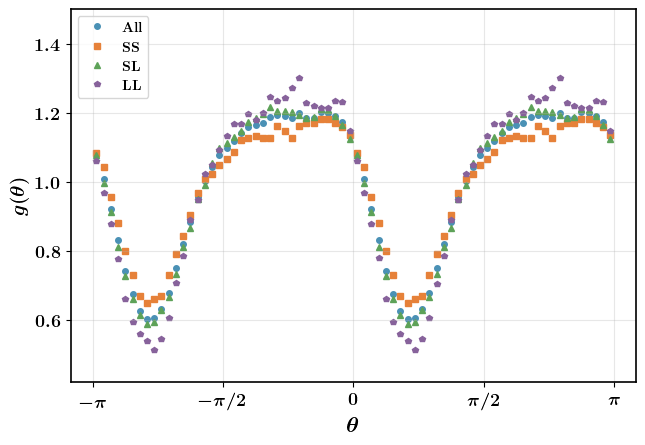

In [94]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define constants and settings
figFormat = ".png"
ranSeedFile = "random_seed.dat"
intFile = "int_random_seed_params_stress100r_shear.dat"

# File path
# topDir = '/Volumes/rahul_2TB/high_bidispersity/new_data/'  # Mac
topDir = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'  # Linux

# Parameters
ar = '1.4'
vr_list = ['0.5']
numRuns = 2
npp = 1000  # Number of particles
off = 100    # Steady state offset

# Phi values for each case
phival = {
    ('0.25', '1.4'): '0.76',
    ('0.5', '1.4') : '0.76',
    ('0.75', '1.4'): '0.77'
}

# Plot settings
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

linestyles = ['None', 'None', 'None', 'None']
sizePair   = ['All', 'SS', 'SL', 'LL']
line_markers = ['o', 's', '^', 'p']

# Helper function
def updateContAngle(theta, contList):
    contList.append(theta)
    if theta < 0:
        contList.append(np.pi - abs(theta))
    else:
        contList.append(theta - np.pi)

# Initialize plot
fig, ax = plt.subplots(figsize=(6.5, 4.5))

# Z-order mapping (one-liner)
zorder_mapping = {'#D80000': 1, '#e68139': 2, '#5da258': 3, '#ADD8E6': 0}

# Loop through volume ratios
for idx, vr in enumerate(vr_list):
    phii = phival[(vr, ar)]
    contactAngleAllRuns = [[] for _ in range(len(sizePair))]

    dataname = f'{topDir}NP_{npp}/phi_{phii}/ar_{ar}/Vr_{vr}'
    if not os.path.exists(dataname):
        continue

    for run in range(numRuns):
        with open(f'{dataname}/run_{run+1}/{ranSeedFile}', 'r') as ranFile:
            particleSize = readFiles.particleSizeList(ranFile, sizeRatio=float(ar))

        with open(f'{dataname}/run_{run+1}/{intFile}', 'r') as interFile:
            contactList = readFiles.interactionsList(interFile)

        contactAngleTotal = [[] for _ in range(len(sizePair))]

        for sampleList in contactList[off:]:
            timeStepContactAngle = [[] for _ in range(len(sizePair))]
            for i in range(sampleList.shape[0]):
                p1, p2 = int(sampleList[i, 0]), int(sampleList[i, 1])
                contState = int(sampleList[i, 10])
                thetaRad = np.arctan2(sampleList[i, 4], sampleList[i, 2])

                if contState == 2:
                    updateContAngle(thetaRad, timeStepContactAngle[0])

                    if particleSize[p1] == particleSize[p2] == 1:
                        updateContAngle(thetaRad, timeStepContactAngle[1])
                    elif particleSize[p1] != particleSize[p2]:
                        updateContAngle(thetaRad, timeStepContactAngle[2])
                    elif particleSize[p1] == particleSize[p2] > 1:
                        updateContAngle(thetaRad, timeStepContactAngle[3])

            for m in range(len(contactAngleTotal)):
                contactAngleTotal[m].append(timeStepContactAngle[m])

        for n in range(len(contactAngleAllRuns)):
            contactAngleList = [angle for sub in contactAngleTotal[n] for angle in sub]
            contactAngleAllRuns[n].append(contactAngleList)

    # Plot
    for im in range(len(contactAngleAllRuns)):
        allAngles = [angle for sub in contactAngleAllRuns[im] for angle in sub]
        counts, bins = np.histogram(allAngles, bins=72, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        countsAvg = np.mean(counts)

        color = colors[idx][im]
        zorder = zorder_mapping.get(color, 1)
        #alpha = 0.2 if color == '#ADD8E6' else 1.0

        ax.plot(bin_centers, counts / countsAvg, linestyle=linestyles[im],
                marker=line_markers[im], markersize=4, alpha=alpha,
                label=fr'$\textbf{{{sizePair[im]}}}$', color=colors[im], zorder=zorder)

# Final plot settings
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlabel(r'$\theta$', fontsize=16)
ax.set_ylabel(r'$g(\theta)$', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.42, 1.5)

# Axis spine styling
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

# Legend and display
ax.legend(fontsize=10, loc='upper left', ncol=1)
plt.tight_layout()
fig.savefig(fig_save_path + 'angularContacts_ar_1.4_all_vr.svg', bbox_inches="tight", dpi=800, transparent=True)
plt.show()

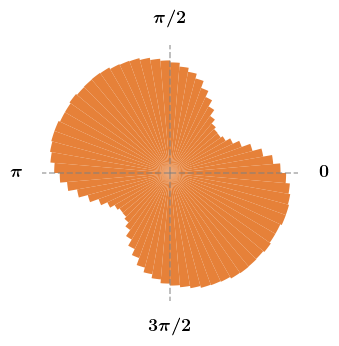

In [121]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define constants and settings
figFormat = ".png"
ranSeedFile = "random_seed.dat"
intFile = "int_random_seed_params_stress100r_shear.dat"

# File path
# topDir = '/Volumes/rahul_2TB/high_bidispersity/new_data/'  # Mac
topDir = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'  # Linux

# Parameters
ar = '1.4'
vr_list = ['0.5']
numRuns = 2
npp = 1000  # Number of particles
off = 100    # Steady state offset

# Phi values for each case
phival = {
    ('0.25', '1.4'): '0.76',
    ('0.5', '1.4') : '0.76',
    ('0.75', '1.4'): '0.77'
}

# Plot settings
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

linestyles = ['None', 'None', 'None', 'None']
sizePair   = ['All']
line_markers = ['o', 's', '^', 'p']

# Helper function
def updateContAngle(theta, contList):
    contList.append(theta)
    if theta < 0:
        contList.append(np.pi - abs(theta))
    else:
        contList.append(theta - np.pi)

# Initialize polar plot
fig, ax = plt.subplots(figsize=(3.5, 3.5), subplot_kw={'projection': 'polar'})

# Customize angular ticks
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'], fontsize=13)

# Hide radial labels and grid
ax.set_yticklabels([])
ax.grid(False)

# Remove the outer circle (polar spine)
ax.spines['polar'].set_visible(False)

# Loop through volume ratios
for idx, vr in enumerate(vr_list):
    phii = phival[(vr, ar)]
    contactAngleAllRuns = [[] for _ in range(len(sizePair))]

    dataname = f'{topDir}NP_{npp}/phi_{phii}/ar_{ar}/Vr_{vr}'
    if not os.path.exists(dataname):
        continue

    for run in range(numRuns):
        with open(f'{dataname}/run_{run+1}/{ranSeedFile}', 'r') as ranFile:
            particleSize = readFiles.particleSizeList(ranFile, sizeRatio=float(ar))

        with open(f'{dataname}/run_{run+1}/{intFile}', 'r') as interFile:
            contactList = readFiles.interactionsList(interFile)

        contactAngleTotal = [[] for _ in range(len(sizePair))]

        for sampleList in contactList[off:]:
            timeStepContactAngle = [[] for _ in range(len(sizePair))]
            for i in range(sampleList.shape[0]):
                p1, p2 = int(sampleList[i, 0]), int(sampleList[i, 1])
                contState = int(sampleList[i, 10])
                thetaRad = np.arctan2(sampleList[i, 4], sampleList[i, 2])

                if contState == 2:
                    updateContAngle(thetaRad, timeStepContactAngle[0])

            for m in range(len(contactAngleTotal)):
                contactAngleTotal[m].append(timeStepContactAngle[m])

        for n in range(len(contactAngleAllRuns)):
            contactAngleList = [angle for sub in contactAngleTotal[n] for angle in sub]
            contactAngleAllRuns[n].append(contactAngleList)

    # Polar bar plot with orange color
    for im in range(len(contactAngleAllRuns)):
        allAngles = [angle for sub in contactAngleAllRuns[im] for angle in sub]
        counts, bins = np.histogram(allAngles, bins=72, range=(-np.pi, np.pi), density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        countsAvg = np.mean(counts)

        ax.bar(bin_centers, counts / countsAvg, width=(2 * np.pi / 72),
               color='#e68139', alpha=1, zorder=2, antialiased=True)
        
for angle in [0, np.pi/2, np.pi, 3*np.pi/2]:
    ax.plot([angle, angle], [0, 1.25], color='gray', linewidth=1.2, linestyle='--', zorder=10,alpha = 0.6)

plt.tight_layout()
fig.savefig(fig_save_path + "contact_angle.svg", bbox_inches='tight', dpi=800, transparent=True)
plt.show()

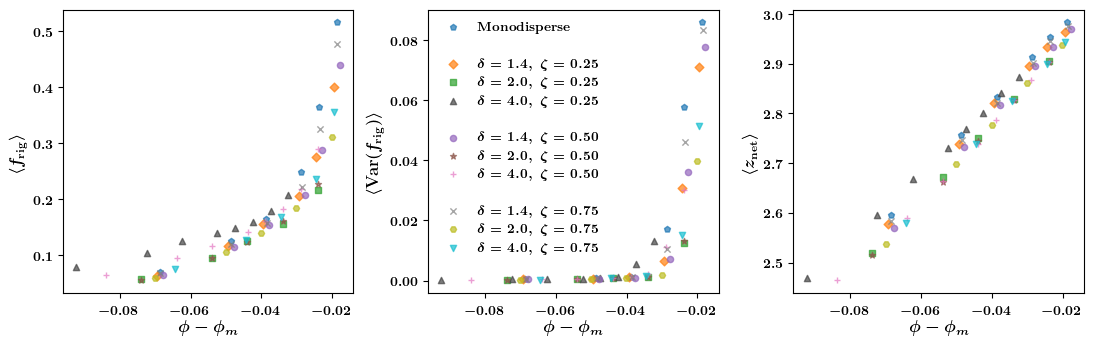

In [101]:
# import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings
import matplotlib.patches as patches
    
# Mac paths
# topDir = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
# fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/paper/'

#linux
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/figures/'

# Parameters
npp          = 1000
phiv         = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
arr          = [1.4, 2.0, 4.0] # 1.0 is a seperate case
vrr          = ['0.25', '0.5', '0.75']
numRuns      = 2
off          = 100
pcount       = 0
totParams    = 2 # total plots
ncols        = 2
nrows        = int(totParams/ ncols)
colors       = ['#1f77b4', '#ff7f0e', '#2ca02c', '#444444',
                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                '#bcbd22', '#17becf', '#f6a821', '#f6d020',
                '#003366', '#cc6699']
marker_shape = ['p', 'D', 's', '^', 'o', '*', '+', 'x', 'H', 'v', '<', '>', '|']
ylables      = [ r'$f_{rig}$', r'$\langle Z_{{net}} \rangle$']

phimall      = []
param        = []
paramserr    = []
zm = []
fig, ax= plt.subplots(1, 3, figsize=(11,3.5))

## plotting ar = 1 and vr = 0.25 case first
for k, phi in enumerate(phiv):
    phir           = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
    param_list     = []
    paramserr_list = []
    zlist =[]
    for run in range(numRuns):
        phim_vals = [(i -  phim[0][0]) for i in phiv]
        workDir   = f"{topDir}NP_{npp}/phi_{phir}/ar_1.0/Vr_0.25/run_{run+1}/"
        
        if os.path.exists(workDir):
            frigFile = workDir + "F_rig.txt"
            frig     = np.loadtxt(frigFile)/ npp

            znetFile = workDir+"Z_Znet.txt"
            znet     = np.loadtxt(znetFile)[:, 2]
            
            param_list.append(np.mean(frig[off:]) if len(frig) > off else None)
            paramserr_list.append(np.var(frig[off:]) if len(frig) > off else None)
            zlist.append(np.mean(znet[off:]))
            
    param.append(np.mean(param_list) if param_list else np.nan)
    paramserr.append(np.mean(paramserr_list) if paramserr_list else np.nan)
    zm.append(np.nanmean(zlist) if zlist else np.nan)
    
param_filtered     = [x for x in param if not np.isnan(x)]
paramerr_filtered  = [x for x in paramserr if not np.isnan(x)]
phim_vals_filtered = [y for x, y in zip(param, phim_vals) if not np.isnan(x)]
z_filtered         = [x for x in zm if not np.isnan(x)]

ax[0].scatter(phim_vals_filtered, param_filtered, marker=marker_shape[pcount], 
            s=20, color=colors[pcount], alpha=0.7,  
            label=r'$\textbf{Monodisperse}$')
ax[1].scatter(phim_vals_filtered, paramerr_filtered, marker=marker_shape[pcount], 
            s=20, color=colors[pcount], alpha=0.7, label=r'$\textbf{Monodisperse}$')
            
ax[2].scatter(phim_vals_filtered, z_filtered, marker=marker_shape[pcount], 
            s=20, color=colors[pcount], alpha=0.7, label=r'$\textbf{Monodisperse}$')  
              
    
pcount += 1
ax[0].plot([], [], ' ', label=" ") 
ax[1].plot([], [], ' ', label=" ")

# plotting other cases
for l, vrl in enumerate(vrr):
    for j, arj in enumerate(arr):
        param     = []
        paramserr = []
        zm = []
        for k, phi in enumerate(phiv):
            phir           = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
            param_list     = []
            paramserr_list = []
            zlist = []
            for run in range(numRuns):
                phim_vals     = [(i - phim[l][j+1]) for i in phiv]
                workDir       = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrl}/run_{run+1}/"
                frigFile = workDir+"F_rig.txt"
                if os.path.exists(frigFile):
                    frigFile = workDir+"F_rig.txt"
                    frig     = np.loadtxt(frigFile)/ npp

                    znetFile = workDir+"Z_Znet.txt"
                    znet     = np.loadtxt(znetFile)[:, 2]
                    
                    if len(frig) > off:
                        param_list.append(np.mean(frig[off:]))
                        paramserr_list.append(np.var(frig[off:]))
                        zlist.append(np.mean(znet[off:]))
                    else:
                        param_list.append(np.nan)
                        paramserr_list.append(np.nan)
                        zlist.append(np.nan)
                        
            # Average over runs for this phi
            param.append(np.nanmean(param_list) if param_list else np.nan)
            paramserr.append(np.nanmean(paramserr_list) if paramserr_list else np.nan)
            zm.append(np.nanmean(zlist) if zlist else np.nan)
            
        # Clean up for plotting
        param_filtered     = [x for x in param if not np.isnan(x)]
        paramerr_filtered  = [x for x in paramserr if not np.isnan(x)]
        phim_vals_filtered = [y for x, y in zip(param, phim_vals) if not np.isnan(x)]
        z_filtered         = [x for x in zm if not np.isnan(x)]
        
        ax[0].scatter(phim_vals_filtered, param_filtered, marker=marker_shape[pcount], 
                    s=20, color=colors[pcount], alpha=0.7,  
                    label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$')
        ax[1].scatter(phim_vals_filtered, paramerr_filtered, marker=marker_shape[pcount], 
                    s=20, color=colors[pcount], alpha=0.7,  
                    label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$')
        ax[2].scatter(phim_vals_filtered, z_filtered, marker=marker_shape[pcount], 
                      s=20, color=colors[pcount], alpha=0.7,  
                      label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$')    
        
        pcount += 1

    ax[0].plot([], [], ' ', label=" ") 
    ax[1].plot([], [], ' ', label=" ") 

labelfont = 12
tickfont = 10  # You can adjust this as needed

for ax_i in ax:
    ax_i.tick_params(axis='both', labelsize=tickfont)

ax[0].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[0].set_ylabel(r'$\langle f_{\mathrm{rig}} \rangle$', fontsize=labelfont)

ax[1].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[1].set_ylabel(r'$\langle \mathrm{Var}(f_{\mathrm{rig}}) \rangle$', fontsize=labelfont)

ax[2].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[2].set_ylabel(r'$\langle z_{\mathrm{net}} \rangle$', fontsize=labelfont)


ax[1].legend(loc='upper left', fontsize=9.5, frameon=False, labelspacing=0.5)

fig.tight_layout()

#plt.savefig(fig_save_path + 'frig_znet_plot.svg', bbox_inches="tight", dpi=800, transparent=True)
plt.show()

In [102]:
phim = [
    [0.7886717028827888, 0.7894387136954615, 0.793926329607985, 0.8324103075865033],
    [0.7886717028827888, 0.7877885526918533, 0.7939236898756902, 0.8239196866554372],
    [0.7886717028827888, 0.7885308930400247, 0.7900830006913417, 0.8044291017153138]
]

/tmp/ipykernel_28629/465200993.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


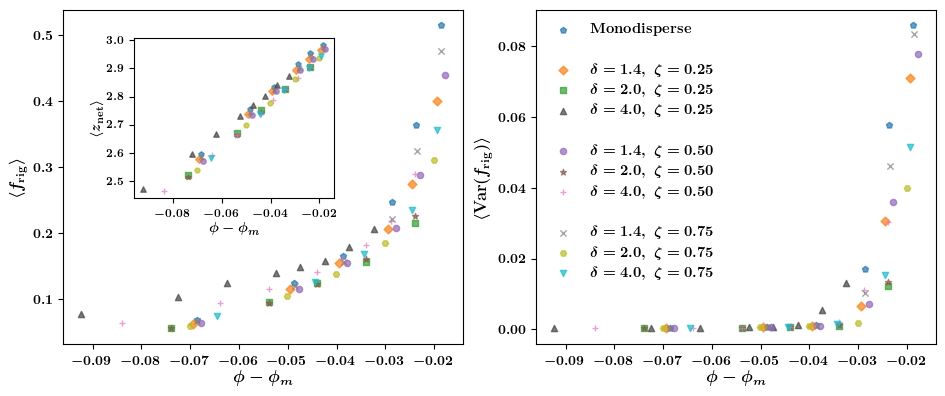

In [118]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Linux paths
topDir = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/EAB2025_poster/figures/'

# Parameters
npp          = 1000
phiv         = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
arr          = [1.4, 2.0, 4.0]
vrr          = ['0.25', '0.5', '0.75']
numRuns      = 2
off          = 100
pcount       = 0
colors       = ['#1f77b4', '#ff7f0e', '#2ca02c', '#444444',
                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                '#bcbd22', '#17becf', '#f6a821', '#f6d020',
                '#003366', '#cc6699']
marker_shape = ['p', 'D', 's', '^', 'o', '*', '+', 'x', 'H', 'v', '<', '>', '|']

phimall = []
param = []
paramserr = []
zm = []

# Create two main plots
fig, axs = plt.subplots(1, 2, figsize=(9.5, 4))

insetwidth = 2
# Inset axis for Z_net in first plot
inset_ax = inset_axes(axs[0], width=insetwidth, height=insetwidth*.8,  # inches
                      loc='upper left',
                      bbox_to_anchor=(0.15, 0.95),  # position (x, y) relative to axs[0]
                      bbox_transform=axs[0].transAxes,
                      borderpad=1)


# Plot monodisperse case
for k, phi in enumerate(phiv):
    phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
    param_list, paramserr_list, zlist = [], [], []
    for run in range(numRuns):
        phim_vals = [(i -  phim[0][0]) for i in phiv]
        workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_1.0/Vr_0.25/run_{run+1}/"

        if os.path.exists(workDir):
            frig = np.loadtxt(workDir + "F_rig.txt") / npp
            znet = np.loadtxt(workDir + "Z_Znet.txt")[:, 2]

            if len(frig) > off:
                param_list.append(np.mean(frig[off:]))
                paramserr_list.append(np.var(frig[off:]))
                zlist.append(np.mean(znet[off:]))

    param.append(np.mean(param_list) if param_list else np.nan)
    paramserr.append(np.mean(paramserr_list) if paramserr_list else np.nan)
    zm.append(np.nanmean(zlist) if zlist else np.nan)

# Clean and plot monodisperse
param_filtered = [x for x in param if not np.isnan(x)]
paramerr_filtered = [x for x in paramserr if not np.isnan(x)]
phim_vals_filtered = [y for x, y in zip(param, phim_vals) if not np.isnan(x)]
z_filtered = [x for x in zm if not np.isnan(x)]

axs[0].scatter(phim_vals_filtered, param_filtered, marker=marker_shape[pcount],
               s=20, color=colors[pcount], alpha=0.7, label=r'$\textbf{Monodisperse}$')
axs[1].scatter(phim_vals_filtered, paramerr_filtered, marker=marker_shape[pcount],
               s=20, color=colors[pcount], alpha=0.7, label=r'$\textbf{Monodisperse}$')
inset_ax.scatter(phim_vals_filtered, z_filtered, marker=marker_shape[pcount],
                 s=15, color=colors[pcount], alpha=0.7)

pcount += 1

# Add spacing line for legend layout
axs[0].plot([], [], ' ', label=" ")
axs[1].plot([], [], ' ', label=" ")

# Plot other bidisperse cases
for l, vrl in enumerate(vrr):
    for j, arj in enumerate(arr):
        param, paramserr, zm = [], [], []
        for k, phi in enumerate(phiv):
            phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
            param_list, paramserr_list, zlist = [], [], []
            for run in range(numRuns):
                phim_vals     = [(i - phim[l][j+1]) for i in phiv]
                workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrl}/run_{run+1}/"
                frigFile = workDir + "F_rig.txt"
                if os.path.exists(frigFile):
                    frig = np.loadtxt(frigFile) / npp
                    znet = np.loadtxt(workDir + "Z_Znet.txt")[:, 2]

                    if len(frig) > off:
                        param_list.append(np.mean(frig[off:]))
                        paramserr_list.append(np.var(frig[off:]))
                        zlist.append(np.mean(znet[off:]))
                    else:
                        param_list.append(np.nan)
                        paramserr_list.append(np.nan)
                        zlist.append(np.nan)

            param.append(np.nanmean(param_list) if param_list else np.nan)
            paramserr.append(np.nanmean(paramserr_list) if paramserr_list else np.nan)
            zm.append(np.nanmean(zlist) if zlist else np.nan)

        # Filter
        param_filtered = [x for x in param if not np.isnan(x)]
        paramerr_filtered = [x for x in paramserr if not np.isnan(x)]
        phim_vals_filtered = [y for x, y in zip(param, phim_vals) if not np.isnan(x)]
        z_filtered = [x for x in zm if not np.isnan(x)]

        axs[0].scatter(phim_vals_filtered, param_filtered, marker=marker_shape[pcount],
                       s=20, color=colors[pcount], alpha=0.7,
                       label=fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$')
        axs[1].scatter(phim_vals_filtered, paramerr_filtered, marker=marker_shape[pcount],
                       s=20, color=colors[pcount], alpha=0.7,
                       label=fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$')
        inset_ax.scatter(phim_vals_filtered, z_filtered, marker=marker_shape[pcount],
                         s=15, color=colors[pcount], alpha=0.7)

        pcount += 1

    axs[0].plot([], [], ' ', label=" ")
    axs[1].plot([], [], ' ', label=" ")

# Final formatting
labelfont = 12
tickfont = 10

for ax_i in axs:
    ax_i.tick_params(axis='both', labelsize=tickfont)

axs[0].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
axs[0].set_ylabel(r'$\langle f_{\mathrm{rig}} \rangle$', fontsize=labelfont)

axs[1].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
axs[1].set_ylabel(r'$\langle \mathrm{Var}(f_{\mathrm{rig}}) \rangle$', fontsize=labelfont)

# Inset formatting
#inset_ax.set_title(r'$\langle z_{\mathrm{net}} \rangle$', fontsize=10, pad=2)
inset_ax.tick_params(axis='both', labelsize=8)
inset_ax.set_xlabel(r'$\phi - \phi_m$', fontsize=10)
inset_ax.set_ylabel(r'$\langle z_{\mathrm{net}} \rangle$', fontsize=10, labelpad=2)

axs[1].legend(loc='upper left', fontsize=10.5, frameon=False, labelspacing=0.5)

fig.tight_layout()
plt.savefig(fig_save_path + 'frig_znet_inset_plot.svg', bbox_inches="tight", dpi=800, transparent=True)
plt.show()